# Tutorial on signal detrending

This tutorial is designed to introduce four different detrending algorithms that can be useful to spectral signal processing.

The algorithms to be introduced in this section are 
- Linear detrending
- adaptive iteratively reweighted penalized least squares (airPLS)
- adaptive reweighted penalized least squares (arPLS)
- corner-cutting algorithm

In [8]:
import numpy as np
from scipy import sparse
from scipy.signal import medfilt
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt

In [9]:
def generate_fake_spectral_data(length=1000, num_peaks=10, noise_level=0.2, poly_degree=2):
    x = np.linspace(0, 10, length)
    spectral_data = np.zeros(length)

    # Generate multiple sinusoidal peaks
    for _ in range(num_peaks):
        amplitude = np.random.uniform(1, 20)  # Varying amplitude of peaks
        frequency = np.random.uniform(0.5, 10)  # Varying frequency of peaks
        phase = np.random.uniform(0, 2 * np.pi)  # Random phase shift for each peak
        peak = amplitude * np.sin(2 * np.pi * frequency * x + phase)
        spectral_data += peak

    # Add a polynomial component
    poly_coefficients = np.random.uniform(-1, 1, poly_degree + 1)  # Random coefficients for the polynomial
    polynomial = np.polyval(poly_coefficients, x)
    spectral_data += polynomial

    # Add noise to the data
    spectral_data_with_noise = spectral_data + noise_level * np.random.randn(length)

    return x, spectral_data_with_noise

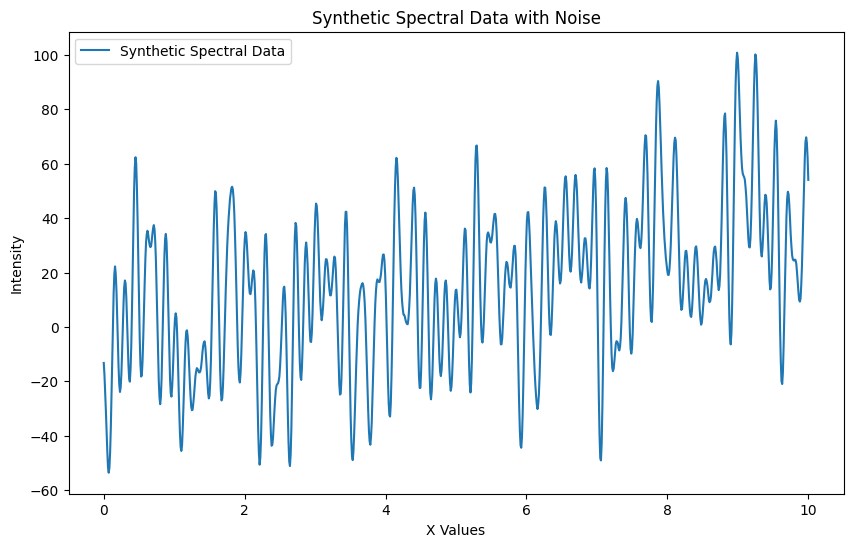

In [10]:
# Generate synthetic spectral data
x_values, synthetic_spectral_data = generate_fake_spectral_data()

# Plotting the generated synthetic spectral data
plt.figure(figsize=(10, 6))
plt.plot(x_values, synthetic_spectral_data, label='Synthetic Spectral Data')
plt.title('Synthetic Spectral Data with Noise')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## Linear detrending algorithm

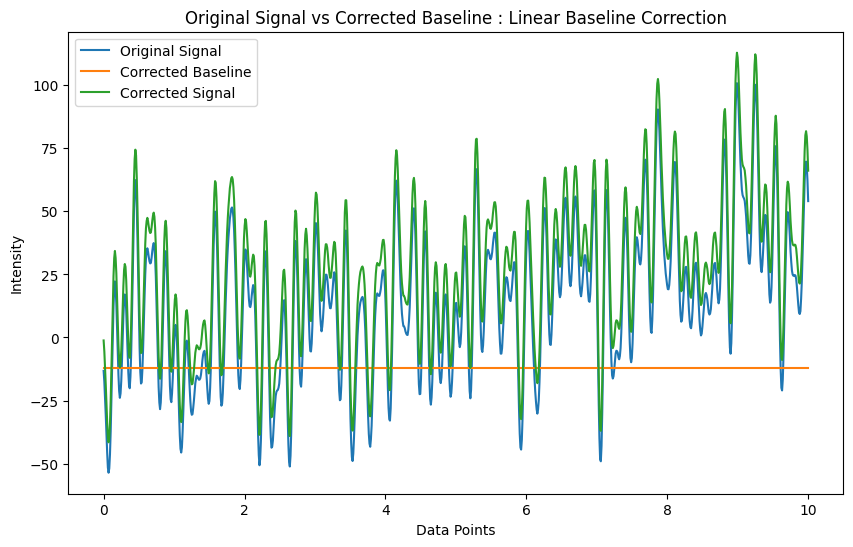

In [11]:
def linear_baseline_correction(spectral_data, window_length=101):
    # Apply median filtering to smooth the data (optional)
    smoothed_data = medfilt(spectral_data, kernel_size=window_length)

    # Fit a linear function to the baseline by selecting appropriate data points
    baseline_indices = np.where(smoothed_data == np.min(smoothed_data))[0]  # Assuming the minimum points represent baseline
    baseline_x = np.arange(len(spectral_data))[baseline_indices]
    baseline_y = smoothed_data[baseline_indices]

    # Fit a linear function (y = mx + c) to the baseline points
    m, c = np.polyfit(baseline_x, baseline_y, 1)

    # Generate the corrected baseline using the linear function
    corrected_baseline = m * np.arange(len(spectral_data)) + c

    return corrected_baseline

# Apply linear baseline correction
linear_corrected_baseline = linear_baseline_correction(synthetic_spectral_data)

# Plotting the original signal and the corrected baseline (using matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(x_values, synthetic_spectral_data, label='Original Signal')
plt.plot(x_values, linear_corrected_baseline, label='Corrected Baseline')
plt.plot(x_values, synthetic_spectral_data - linear_corrected_baseline, label='Corrected Signal')
plt.legend()
plt.title('Original Signal vs Corrected Baseline : Linear Baseline Correction')
plt.xlabel('Data Points')
plt.ylabel('Intensity')
plt.show()


## airPLS

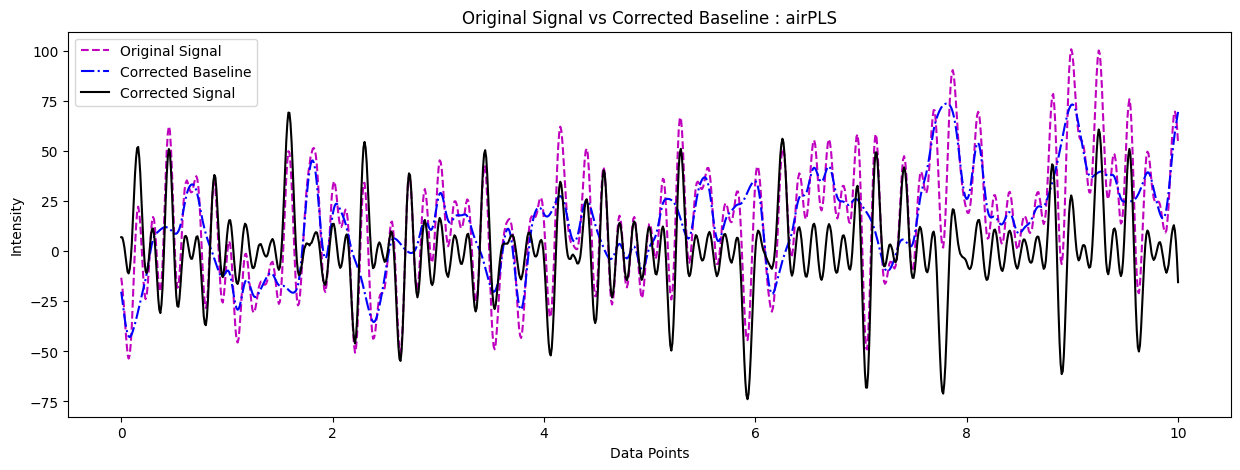

In [12]:
def airPLS(y, lambda_=100, itermax=15):
    '''
    AirPLS baseline correction algorithm.
    
    y: input signal (spectral data)
    lambda_: parameter controlling the smoothness of the baseline
    itermax: maximum number of iterations
    
    Returns:
    baseline-corrected signal
    '''
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    W = np.ones(L)
    for i in range(itermax):
        Z = sparse.spdiags(W, 0, L, L)
        C = Z + lambda_ * D.dot(D.transpose())
        baseline = spsolve(C, Z.dot(y))
        W = np.abs(y - baseline) < 2 * np.sqrt(np.median((y - baseline) ** 2))
    
    return baseline

# Apply linear baseline correction
airPLS_corrected_baseline = airPLS(synthetic_spectral_data)

# Plotting the original signal and the corrected baseline (using matplotlib)
plt.figure(figsize=(15, 5))
plt.plot(x_values, synthetic_spectral_data, 'm--', label='Original Signal')
plt.plot(x_values, airPLS_corrected_baseline, 'b-.', label='Corrected Baseline')
plt.plot(x_values, synthetic_spectral_data - airPLS_corrected_baseline, 'k-', label='Corrected Signal')
plt.legend()
plt.title('Original Signal vs Corrected Baseline : airPLS')
plt.xlabel('Data Points')
plt.ylabel('Intensity')
plt.show()

## arPLS

Maximum number of iterations exceeded


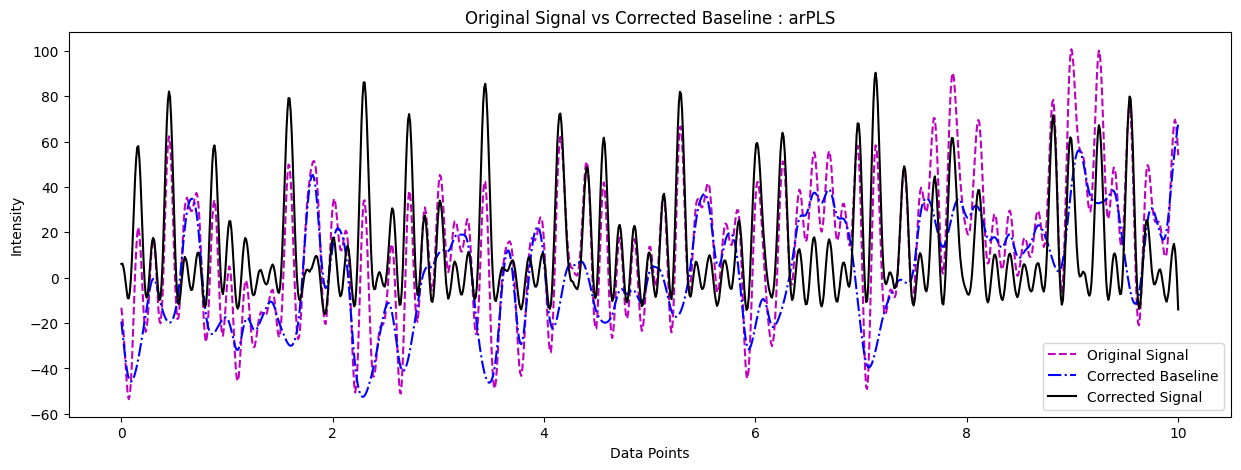

In [13]:
def arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        baseline = spsolve(W + H, W * y)
        d = y - baseline
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = np.linalg.norm(w_new - w) / np.linalg.norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return baseline, d, info
    else:
        return baseline

# Apply linear baseline correction
arPLS_corrected_baseline = arPLS(synthetic_spectral_data)

# Plotting the original signal and the corrected baseline (using matplotlib)
plt.figure(figsize=(15, 5))
plt.plot(x_values, synthetic_spectral_data, 'm--', label='Original Signal')
plt.plot(x_values, arPLS_corrected_baseline, 'b-.', label='Corrected Baseline')
plt.plot(x_values, synthetic_spectral_data - arPLS_corrected_baseline, 'k-', label='Corrected Signal')
plt.legend()
plt.title('Original Signal vs Corrected Baseline : arPLS')
plt.xlabel('Data Points')
plt.ylabel('Intensity')
plt.show()

Comparison between arPLS and airPLS

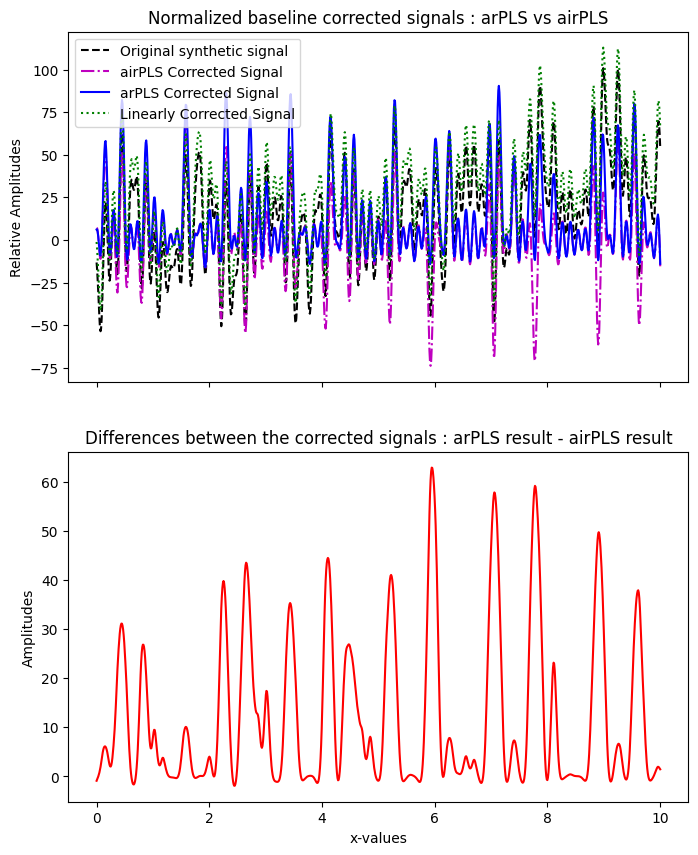

In [16]:
ar  = synthetic_spectral_data - arPLS_corrected_baseline
air = synthetic_spectral_data - airPLS_corrected_baseline
lin = synthetic_spectral_data - linear_corrected_baseline
#ar  = ar / np.linalg.norm(ar)
#air = air/ np.linalg.norm(air)
#lin = lin/ np.linalg.norm(lin)

# Creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plotting on the first subplot (top)
ax1.plot(x_values, synthetic_spectral_data, 'k--', label='Original synthetic signal')
ax1.plot(x_values, air, 'm-.', label='airPLS Corrected Signal')
ax1.plot(x_values, ar, 'b-', label='arPLS Corrected Signal')
ax1.plot(x_values, lin, 'g:', label='Linearly Corrected Signal')
ax1.plot()
#ax1.plot(x_values, synthetic_spectral_data / np.linalg.norm(synthetic_spectral_data) - 0.1, '-', label='Original Signal')
ax1.set_title("Normalized baseline corrected signals : arPLS vs airPLS")
ax1.set_ylabel('Relative Amplitudes')
ax1.legend()

# Plotting on the second subplot (bottom)
ax2.plot(x_values, ar - air, color='red')
ax2.set_ylabel('Amplitudes')
ax2.set_title("Differences between the corrected signals : arPLS result - airPLS result")
ax2.set_xlabel('x-values')

plt.show()